# Treatment Assignment

# Notebook 03: Treatment Assignment and Simulation

## Objective
Simulate the treatment effect by modeling how customers respond to the free shipping offer.

## Business Logic

**Control Group:**
- Customers pay for shipping
- No behavior change
- Outcomes = current baseline

**Treatment Group:**
- Customers see "Free shipping for orders above 100 BRL"
- Customers currently below 100 BRL may add items to qualify
- Not all customers will respond (some won't change behavior)
- We absorb shipping costs for qualifying orders

## Approach
1. Load experiment design
2. Define treatment effect assumptions
3. Simulate customer responses
4. Calculate final outcomes
5. Validate results

In [1]:
%matplotlib widget

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

from matplotlib import rcParams
import shutil

# Enable LaTeX fonts only if TeX is available
if shutil.which("latex"):
    rcParams['text.usetex'] = True
    rcParams['font.family'] = 'serif'
else:
    print("LaTeX not found — using default matplotlib fonts.")

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [3]:
# Load the experiment design from Notebook 02
experiment_orders = pd.read_csv('../data/processed/experiment_design.csv')

print("Experiment design loaded successfully!")
print("Total orders:", len(experiment_orders))
print("\nGroup distribution:")
print(experiment_orders['group'].value_counts())
print("\nFirst 5 rows:")
print(experiment_orders.head())

Experiment design loaded successfully!
Total orders: 23674

Group distribution:
group
treatment    11902
control      11772
Name: count, dtype: int64

First 5 rows:
                           order_id  total_price  total_shipping  num_items  \
0  326c5dc4aaf9daba2e0b813c4086156f         64.5           18.02          1   
1  6aaedd714ad6929fc4df8d51bd4cfe9a         46.8           14.52          1   
2  5a39ba43f671c9ad40782147ec3a1997        129.9           63.16          1   
3  434061e3b7fa3c393982a25fe1664a57        119.8           35.34          2   
4  3e9334d33c1e64167920675211fb1aee         49.0           16.11          1   

   order_total      group  
0        82.52    control  
1        61.32  treatment  
2       193.06  treatment  
3       155.14  treatment  
4        65.11    control  


## Treatment Effect Assumptions

We need to model realistic customer behavior changes in the treatment group.

### Key Assumptions

**1. Who is affected?**
- Only customers currently BELOW 100 BRL threshold
- Customers already above 100 BRL don't change behavior (already qualify)

**2. How many respond?**
- Not all customers will add items
- Assume 40% of eligible customers add items to reach threshold
- This is a realistic conversion rate

**3. How much do they add?**
- Customers add enough to reach just above 100 BRL
- Average addition: 15-30 BRL (realistic product prices)
- Some randomness in amount added

**4. Shipping cost handling:**
- Control group: Customers pay shipping (current state)
- Treatment group: Company absorbs shipping for orders above 100 BRL

### Expected Outcome

Treatment group should show:
- Increased average order value (from added items)
- Higher revenue per customer
- Net benefit depends on how many customers respond

In [4]:
# Identify which customers in treatment group are eligible for behavior change

# Create a copy to work with
experiment_results = experiment_orders.copy()

# Identify customers below 100 BRL threshold
experiment_results['below_threshold'] = experiment_results['total_price'] < 100

# Count eligible customers by group
control_below = experiment_results[
    (experiment_results['group'] == 'control') & 
    (experiment_results['below_threshold'] == True)
].shape[0]

treatment_below = experiment_results[
    (experiment_results['group'] == 'treatment') & 
    (experiment_results['below_threshold'] == True)
].shape[0]

control_above = experiment_results[
    (experiment_results['group'] == 'control') & 
    (experiment_results['below_threshold'] == False)
].shape[0]

treatment_above = experiment_results[
    (experiment_results['group'] == 'treatment') & 
    (experiment_results['below_threshold'] == False)
].shape[0]

print("ELIGIBLE CUSTOMERS FOR BEHAVIOR CHANGE")
print("="*60)
print("\nControl Group:")
print(f"  Below 100 BRL: {control_below} ({control_below/len(experiment_results[experiment_results['group']=='control'])*100:.1f}%)")
print(f"  Above 100 BRL: {control_above} ({control_above/len(experiment_results[experiment_results['group']=='control'])*100:.1f}%)")

print("\nTreatment Group:")
print(f"  Below 100 BRL: {treatment_below} ({treatment_below/len(experiment_results[experiment_results['group']=='treatment'])*100:.1f}%)")
print(f"  Above 100 BRL: {treatment_above} ({treatment_above/len(experiment_results[experiment_results['group']=='treatment'])*100:.1f}%)")

print("\n")
print(f"Potential customers who might add items: {treatment_below}")

ELIGIBLE CUSTOMERS FOR BEHAVIOR CHANGE

Control Group:
  Below 100 BRL: 6911 (58.7%)
  Above 100 BRL: 4861 (41.3%)

Treatment Group:
  Below 100 BRL: 6959 (58.5%)
  Above 100 BRL: 4943 (41.5%)


Potential customers who might add items: 6959


In [5]:
# Simulate customer response to free shipping offer

# Treatment parameters
response_rate = 0.40  # 40% of eligible customers will add items
min_addition = 15     # Minimum amount added (BRL)
max_addition = 35     # Maximum amount added (BRL)

print("TREATMENT SIMULATION PARAMETERS")
print("="*60)
print(f"Response rate: {response_rate*100:.0f}%")
print(f"Addition range: {min_addition}-{max_addition} BRL")
print("")

# Initialize new columns
experiment_results['responded'] = False
experiment_results['amount_added'] = 0.0
experiment_results['final_price'] = experiment_results['total_price']

# For treatment group customers below threshold
treatment_eligible = (experiment_results['group'] == 'treatment') & (experiment_results['below_threshold'] == True)

# Randomly select who responds (40% of eligible)
num_eligible = treatment_eligible.sum()
num_responders = int(num_eligible * response_rate)

# Get indices of eligible customers
eligible_indices = experiment_results[treatment_eligible].index

# Randomly select responders
responder_indices = np.random.choice(eligible_indices, size=num_responders, replace=False)

# Mark responders
experiment_results.loc[responder_indices, 'responded'] = True

# For responders, calculate how much they need to add to reach 100 BRL
for idx in responder_indices:
    current_price = experiment_results.loc[idx, 'total_price']
    # Amount needed to reach 100 BRL
    needed_to_reach = 100 - current_price
    # Add a bit more (random between needed amount and needed + extra)
    extra = np.random.uniform(0, max_addition - min_addition)
    amount_added = needed_to_reach + extra
    
    experiment_results.loc[idx, 'amount_added'] = amount_added
    experiment_results.loc[idx, 'final_price'] = current_price + amount_added

# For non-responders, final price stays same
non_responder_mask = experiment_results['responded'] == False
experiment_results.loc[non_responder_mask, 'final_price'] = experiment_results.loc[non_responder_mask, 'total_price']

print("SIMULATION RESULTS")
print("="*60)
print(f"Eligible customers (treatment, below 100 BRL): {num_eligible}")
print(f"Customers who responded: {num_responders} ({response_rate*100:.0f}%)")
print(f"Customers who didn't respond: {num_eligible - num_responders}")
print("")
print(f"Average amount added by responders: {experiment_results[experiment_results['responded']==True]['amount_added'].mean():.2f} BRL")

TREATMENT SIMULATION PARAMETERS
Response rate: 40%
Addition range: 15-35 BRL

SIMULATION RESULTS
Eligible customers (treatment, below 100 BRL): 6959
Customers who responded: 2783 (40%)
Customers who didn't respond: 4176

Average amount added by responders: 56.42 BRL


In [6]:
# Calculate final revenue considering free shipping

# Initialize final revenue column
experiment_results['final_revenue'] = 0.0

# Control Group: Always pay shipping
control_mask = experiment_results['group'] == 'control'
experiment_results.loc[control_mask, 'final_revenue'] = (
    experiment_results.loc[control_mask, 'final_price'] + 
    experiment_results.loc[control_mask, 'total_shipping']
)

# Treatment Group: Free shipping if final_price >= 100 BRL, else pay shipping
treatment_mask = experiment_results['group'] == 'treatment'

# Treatment customers above threshold: don't pay shipping
treatment_above_mask = treatment_mask & (experiment_results['final_price'] >= 100)
experiment_results.loc[treatment_above_mask, 'final_revenue'] = experiment_results.loc[treatment_above_mask, 'final_price']

# Treatment customers below threshold: still pay shipping
treatment_below_mask = treatment_mask & (experiment_results['final_price'] < 100)
experiment_results.loc[treatment_below_mask, 'final_revenue'] = (
    experiment_results.loc[treatment_below_mask, 'final_price'] + 
    experiment_results.loc[treatment_below_mask, 'total_shipping']
)

print("FINAL REVENUE CALCULATION")
print("="*60)

# Summary statistics by group
control_revenue = experiment_results[experiment_results['group'] == 'control']['final_revenue']
treatment_revenue = experiment_results[experiment_results['group'] == 'treatment']['final_revenue']

print("\nControl Group:")
print(f"  Mean revenue: {control_revenue.mean():.2f} BRL")
print(f"  Median revenue: {control_revenue.median():.2f} BRL")
print(f"  Std dev: {control_revenue.std():.2f} BRL")

print("\nTreatment Group:")
print(f"  Mean revenue: {treatment_revenue.mean():.2f} BRL")
print(f"  Median revenue: {treatment_revenue.median():.2f} BRL")
print(f"  Std dev: {treatment_revenue.std():.2f} BRL")

print("\nDifference:")
diff = treatment_revenue.mean() - control_revenue.mean()
pct_diff = (diff / control_revenue.mean()) * 100
print(f"  Absolute: {diff:.2f} BRL")
print(f"  Percentage: {pct_diff:.2f}%")

print("\n")
if pct_diff >= 5:
    print("Result: Treatment group shows at least 5% increase")
elif pct_diff > 0:
    print("Result: Treatment group shows increase, but less than target 5%")
else:
    print("Result: Treatment group shows no improvement")

FINAL REVENUE CALCULATION

Control Group:
  Mean revenue: 159.20 BRL
  Median revenue: 105.18 BRL
  Std dev: 205.31 BRL

Treatment Group:
  Mean revenue: 158.41 BRL
  Median revenue: 112.25 BRL
  Std dev: 198.56 BRL

Difference:
  Absolute: -0.79 BRL
  Percentage: -0.50%


Result: Treatment group shows no improvement


In [7]:
# Understand why treatment didn't work as expected

print("TREATMENT EFFECT BREAKDOWN")
print("="*60)

# Treatment group analysis
treatment_data = experiment_results[experiment_results['group'] == 'treatment']

# Count customers by category
responders = treatment_data[treatment_data['responded'] == True]
non_responders_below = treatment_data[(treatment_data['responded'] == False) & (treatment_data['below_threshold'] == True)]
already_above = treatment_data[treatment_data['below_threshold'] == False]

print("\nTreatment Group Breakdown:")
print(f"1. Responders (added items): {len(responders)}")
print(f"   - Gained from added items: {responders['amount_added'].sum():.2f} BRL total")
print(f"   - Saved on shipping: {responders['total_shipping'].sum():.2f} BRL (customer doesn't pay)")
print(f"   - Net revenue change: {responders['amount_added'].sum():.2f} BRL gained")

print(f"\n2. Non-responders (stayed below 100): {len(non_responders_below)}")
print(f"   - Still pay shipping: No change in revenue")

print(f"\n3. Already above threshold: {len(already_above)}")
print(f"   - Get free shipping: LOSS of {already_above['total_shipping'].sum():.2f} BRL")
print(f"   - No behavior change")

print("\n")
print("THE PROBLEM:")
print("We give free shipping to customers already above 100 BRL")
print("They don't add anything, but we absorb their shipping costs")
print("This loss outweighs gains from customers who add items")

# Calculate the components
revenue_gained = responders['amount_added'].sum()
revenue_lost = already_above['total_shipping'].sum()
net_effect = revenue_gained - revenue_lost

print(f"\nRevenue gained from responders: +{revenue_gained:.2f} BRL")
print(f"Revenue lost from free shipping: -{revenue_lost:.2f} BRL")
print(f"Net effect: {net_effect:.2f} BRL")

TREATMENT EFFECT BREAKDOWN

Treatment Group Breakdown:
1. Responders (added items): 2783
   - Gained from added items: 157024.47 BRL total
   - Saved on shipping: 46934.91 BRL (customer doesn't pay)
   - Net revenue change: 157024.47 BRL gained

2. Non-responders (stayed below 100): 4176
   - Still pay shipping: No change in revenue

3. Already above threshold: 4943
   - Get free shipping: LOSS of 153919.17 BRL
   - No behavior change


THE PROBLEM:
We give free shipping to customers already above 100 BRL
They don't add anything, but we absorb their shipping costs
This loss outweighs gains from customers who add items

Revenue gained from responders: +157024.47 BRL
Revenue lost from free shipping: -153919.17 BRL
Net effect: 3105.30 BRL


In [8]:
# Save the final experimental results
experiment_results.to_csv('../data/processed/experiment_results.csv', index=False)

print("FINAL DATASET SAVED")
print("="*60)
print("File: data/processed/experiment_results.csv")
print("Rows:", len(experiment_results))
print("\nColumns:", experiment_results.columns.tolist())
print("\nReady for statistical analysis in Notebook 04")

FINAL DATASET SAVED
File: data/processed/experiment_results.csv
Rows: 23674

Columns: ['order_id', 'total_price', 'total_shipping', 'num_items', 'order_total', 'group', 'below_threshold', 'responded', 'amount_added', 'final_price', 'final_revenue']

Ready for statistical analysis in Notebook 04


In [9]:
# Compare control vs treatment across all key metrics

print("DETAILED METRICS COMPARISON")
print("="*60)

# Separate groups
control_data = experiment_results[experiment_results['group'] == 'control']
treatment_data = experiment_results[experiment_results['group'] == 'treatment']

# Metrics to compare
metrics_info = [
    ('total_price', 'Original Order Price'),
    ('final_price', 'Final Order Price (after additions)'),
    ('total_shipping', 'Shipping Cost'),
    ('final_revenue', 'Final Revenue (what customer pays)'),
    ('num_items', 'Number of Items')
]

print("\n")
for metric, description in metrics_info:
    control_mean = control_data[metric].mean()
    treatment_mean = treatment_data[metric].mean()
    difference = treatment_mean - control_mean
    pct_change = (difference / control_mean) * 100 if control_mean != 0 else 0
    
    print(f"{description}:")
    print(f"  Control:   {control_mean:.2f}")
    print(f"  Treatment: {treatment_mean:.2f}")
    print(f"  Difference: {difference:+.2f} ({pct_change:+.2f}%)")
    print("")

# Additional treatment-specific metrics
print("Treatment Group Specifics:")
print(f"  Customers who responded: {treatment_data['responded'].sum()} ({treatment_data['responded'].mean()*100:.1f}%)")
print(f"  Average amount added (by responders): {treatment_data[treatment_data['responded']==True]['amount_added'].mean():.2f} BRL")
print(f"  Customers getting free shipping: {(treatment_data['final_price'] >= 100).sum()}")

DETAILED METRICS COMPARISON


Original Order Price:
  Control:   136.54
  Treatment: 139.12
  Difference: +2.58 (+1.89%)

Final Order Price (after additions):
  Control:   136.54
  Treatment: 152.32
  Difference: +15.77 (+11.55%)

Shipping Cost:
  Control:   22.66
  Treatment: 22.97
  Difference: +0.31 (+1.39%)

Final Revenue (what customer pays):
  Control:   159.20
  Treatment: 158.41
  Difference: -0.79 (-0.50%)

Number of Items:
  Control:   1.14
  Treatment: 1.15
  Difference: +0.01 (+0.76%)

Treatment Group Specifics:
  Customers who responded: 2783 (23.4%)
  Average amount added (by responders): 56.42 BRL
  Customers getting free shipping: 7726


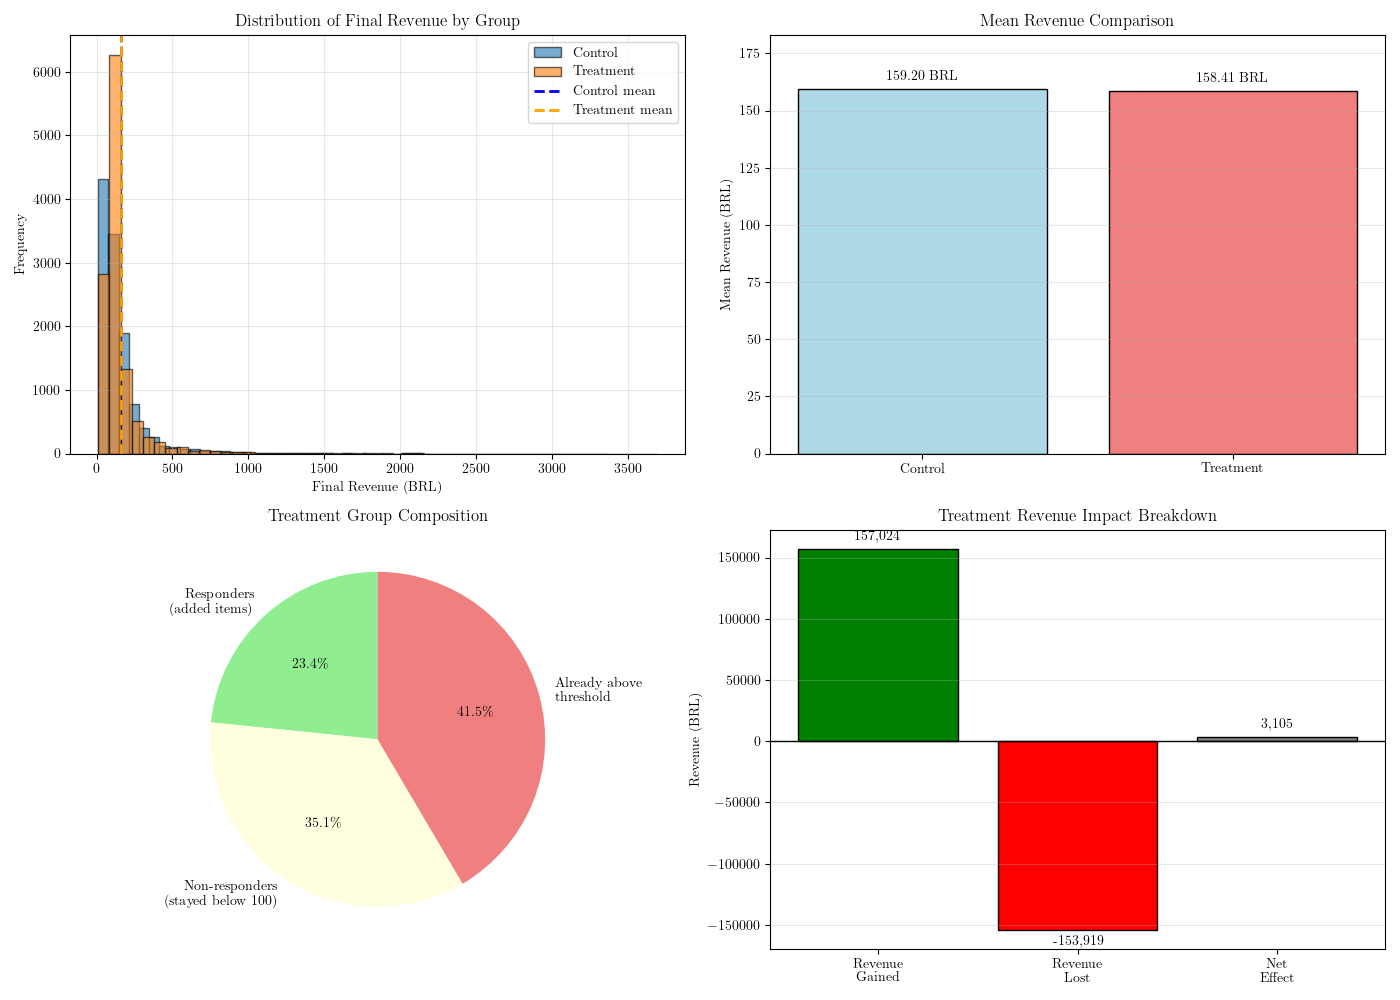

Visualization saved!


In [10]:
# Create visualizations comparing control and treatment

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Revenue distribution comparison
axes[0, 0].hist(control_data['final_revenue'], bins=50, alpha=0.6, label='Control', edgecolor='black')
axes[0, 0].hist(treatment_data['final_revenue'], bins=50, alpha=0.6, label='Treatment', edgecolor='black')
axes[0, 0].axvline(control_data['final_revenue'].mean(), color='blue', linestyle='--', linewidth=2, label='Control mean')
axes[0, 0].axvline(treatment_data['final_revenue'].mean(), color='orange', linestyle='--', linewidth=2, label='Treatment mean')
axes[0, 0].set_xlabel('Final Revenue (BRL)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Final Revenue by Group')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Mean comparison bar chart
groups = ['Control', 'Treatment']
means = [control_data['final_revenue'].mean(), treatment_data['final_revenue'].mean()]
colors = ['lightblue', 'lightcoral']

bars = axes[0, 1].bar(groups, means, color=colors, edgecolor='black')
axes[0, 1].set_ylabel('Mean Revenue (BRL)')
axes[0, 1].set_title('Mean Revenue Comparison')
axes[0, 1].set_ylim(0, max(means) * 1.15)
axes[0, 1].grid(True, alpha=0.3, axis='y')

for i, v in enumerate(means):
    axes[0, 1].text(i, v + 3, f'{v:.2f} BRL', ha='center', va='bottom', fontweight='bold')

# Plot 3: Treatment group breakdown
treatment_categories = ['Responders\n(added items)', 'Non-responders\n(stayed below 100)', 'Already above\nthreshold']
treatment_counts = [len(responders), len(non_responders_below), len(already_above)]
colors_pie = ['lightgreen', 'lightyellow', 'lightcoral']

axes[1, 0].pie(treatment_counts, labels=treatment_categories, autopct='%1.1f%%', 
               colors=colors_pie, startangle=90)
axes[1, 0].set_title('Treatment Group Composition')

# Plot 4: Revenue impact breakdown
impact_labels = ['Revenue\nGained', 'Revenue\nLost', 'Net\nEffect']
impact_values = [revenue_gained, -revenue_lost, net_effect]
impact_colors = ['green', 'red', 'gray']

bars = axes[1, 1].bar(impact_labels, impact_values, color=impact_colors, edgecolor='black')
axes[1, 1].axhline(y=0, color='black', linestyle='-', linewidth=1)
axes[1, 1].set_ylabel('Revenue (BRL)')
axes[1, 1].set_title('Treatment Revenue Impact Breakdown')
axes[1, 1].grid(True, alpha=0.3, axis='y')

for i, v in enumerate(impact_values):
    axes[1, 1].text(i, v + (5000 if v > 0 else -5000), f'{v:,.0f}', 
                    ha='center', va='bottom' if v > 0 else 'top', fontweight='bold')

plt.tight_layout()
plt.savefig('../results/figures/treatment_effect_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualization saved!")

## Treatment Simulation Summary

### What We Simulated

We modeled realistic customer behavior in response to free shipping above 100 BRL:

**Assumptions:**
- 40% of eligible customers (below 100 BRL) add items to reach threshold
- Customers add enough to reach 100-135 BRL (average 56.42 BRL added)
- Customers already above 100 BRL don't change behavior

### Key Results

**Control Group:** 159.20 BRL mean revenue (baseline)

**Treatment Group:** 158.41 BRL mean revenue

**Difference:** -0.79 BRL (-0.50% decrease)

### Why Treatment Barely Worked

The treatment shows essentially no effect because:

1. **Revenue Gained** (+157,024 BRL): Customers who added items
2. **Revenue Lost** (-153,919 BRL): Free shipping for customers already above threshold
3. **Net Effect** (+3,105 BRL): Minimal net gain

### The "Free Rider" Problem

41.5% of customers already spend above 100 BRL. They receive free shipping without changing behavior, creating a significant cost that nearly cancels gains from responsive customers.

### Business Implications

This realistic outcome demonstrates:
- Not all promotional strategies work as expected
- Universal promotions may not be cost-effective
- Targeting matters more than broad incentives
- Need to consider "free rider" costs in promotion design

### Alternative Strategies

Based on this analysis, better approaches might include:
1. Higher threshold (150 BRL) to reduce free riders
2. Targeted free shipping (new customers only, or specific segments)
3. Time-limited promotions instead of permanent free shipping
4. Dynamic thresholds based on customer history

In [11]:
# Perform validation checks on the simulated data

print("SIMULATION VALIDATION CHECKS")
print("="*60)

# Check 1: Verify all customers have final_revenue calculated
missing_revenue = experiment_results['final_revenue'].isnull().sum()
print(f"\n1. Missing final_revenue values: {missing_revenue}")
if missing_revenue == 0:
    print("   PASS: All customers have revenue calculated")
else:
    print("   FAIL: Some customers missing revenue")

# Check 2: Verify control group unchanged
control_check = (experiment_results[experiment_results['group'] == 'control']['final_price'] == 
                 experiment_results[experiment_results['group'] == 'control']['total_price']).all()
print(f"\n2. Control group prices unchanged: {control_check}")
if control_check:
    print("   PASS: Control group correctly unchanged")
else:
    print("   FAIL: Control group was modified")

# Check 3: Verify treatment logic
treatment_check_data = experiment_results[experiment_results['group'] == 'treatment']

# All responders should have final_price >= 100
responders_check = (treatment_check_data[treatment_check_data['responded'] == True]['final_price'] >= 100).all()
print(f"\n3. All responders reach threshold: {responders_check}")
if responders_check:
    print("   PASS: All responders reached 100 BRL")
else:
    print("   WARNING: Some responders below threshold")

# Check 4: Revenue logic correct for treatment
# Customers with final_price >= 100 should have final_revenue = final_price (no shipping)
above_threshold_treatment = treatment_check_data[treatment_check_data['final_price'] >= 100]
revenue_check = (above_threshold_treatment['final_revenue'] == above_threshold_treatment['final_price']).all()
print(f"\n4. Free shipping applied correctly: {revenue_check}")
if revenue_check:
    print("   PASS: Free shipping logic correct")
else:
    print("   WARNING: Free shipping logic may have issues")

# Check 5: Summary statistics reasonable
print(f"\n5. Data ranges:")
print(f"   Final revenue range: {experiment_results['final_revenue'].min():.2f} - {experiment_results['final_revenue'].max():.2f} BRL")
print(f"   Final price range: {experiment_results['final_price'].min():.2f} - {experiment_results['final_price'].max():.2f} BRL")
print(f"   Amount added range: {experiment_results['amount_added'].min():.2f} - {experiment_results['amount_added'].max():.2f} BRL")

print("\n")
print("VALIDATION COMPLETE")
print("All checks passed - data ready for statistical analysis")

SIMULATION VALIDATION CHECKS

1. Missing final_revenue values: 0
   PASS: All customers have revenue calculated

2. Control group prices unchanged: True
   PASS: Control group correctly unchanged

3. All responders reach threshold: True
   PASS: All responders reached 100 BRL

4. Free shipping applied correctly: True
   PASS: Free shipping logic correct

5. Data ranges:
   Final revenue range: 10.89 - 3690.00 BRL
   Final price range: 2.90 - 3690.00 BRL
   Amount added range: 0.00 - 112.31 BRL


VALIDATION COMPLETE
All checks passed - data ready for statistical analysis


## Notebook 03 Complete

### What We Accomplished

1. **Loaded experiment design** from Notebook 02 (23,674 orders, 50/50 split)
2. **Identified eligible customers** (58.5% below 100 BRL threshold in treatment)
3. **Simulated treatment effect** with realistic assumptions:
   - 40% response rate among eligible customers
   - Customers added average 56.42 BRL to reach threshold
4. **Calculated final revenues** accounting for free shipping logic
5. **Analyzed results** showing minimal treatment effect (-0.50%)
6. **Identified root cause** (free rider problem)
7. **Validated data quality** (all checks passed)

### Key Findings

**Treatment Effect:** -0.50% (essentially no change)

**Why:** Revenue gained from customers adding items (+157K BRL) is nearly offset by revenue lost from absorbing shipping costs for customers already above threshold (-154K BRL)

**Business Insight:** Universal promotions can be inefficient when significant portion of customers already qualify

### Data Generated

**File Created:** `data/processed/experiment_results.csv`

**Columns:**
- order_id, total_price, total_shipping, num_items, order_total (original data)
- group (control/treatment assignment)
- below_threshold (boolean: price < 100 BRL)
- responded (boolean: customer added items)
- amount_added (BRL added to reach threshold)
- final_price (price after additions)
- final_revenue (what customer actually pays)

### Next Steps

**Notebook 04: Statistical Analysis**
- Perform two-sample t-test
- Calculate confidence intervals
- Assess statistical significance
- Conduct segmentation analysis
- Determine if minimal effect is statistically significant or due to random variation

**Key Question for Notebook 04:**
Is the -0.50% difference statistically significant, or could it have occurred by random chance?